In [27]:
import numpy as np
import mne
from mne_connectivity import spectral_connectivity_epochs
from spectral_connectivity import Multitaper, Connectivity
import dynsys_orig_2 as dynsys
import seaborn as sns
from matplotlib import pyplot as plt

In [23]:
#v2
sfreq = 100
tmin = 0 # s
tmax = 100 # s
time = np.arange(tmin, tmax, 1/sfreq) 
rho = 0.95

np.random.seed(1000)
noise1 = np.random.randn(len(time))
noise2 = np.random.randn(len(time))
noise3 = np.random.randn(len(time))

y1_a2 = np.zeros(len(time))
y2_a2 = np.zeros(len(time))
y3_a2 = np.zeros(len(time))

#### y1, y2 present

In [24]:
for i in np.arange(2, len(time)):
    y3_a2[i] = -(rho**2)*y3_a2[i-2] + noise3[i]
    y1_a2[i] = y3_a2[i-2]-(rho**2)*y1_a2[i-2] + noise1[i]
    y2_a2[i] = y3_a2[i-2] + y1_a2[i-2] - (rho**2)*y2_a2[i-2] + noise2[i]

In [25]:
## simulated data
sim_data = np.array([y1_a2,y2_a2,y3_a2])
info = mne.create_info(ch_names=["y1", "y2", "y3"], ch_types=["eeg"]*3, sfreq=100)
simulated_raw = mne.io.RawArray(sim_data, info)
epochs = mne.make_fixed_length_epochs(simulated_raw, duration=10)

## estimations
#dynsys
epoch_idx = np.arange(1)
region = ['y1','y2','y3']
dynsys_mat,cond_num,mse,snr = dynsys.dynSys(epochs.get_data(), epoch_idx, region, sampling_time=0.01)

#coh 
mne_con = spectral_connectivity_epochs(epochs, method='coh', sfreq=sfreq, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
coh_mat = mne_con.get_data(output="dense")

#ciplv
mne_con = spectral_connectivity_epochs(epochs, method='ciplv', sfreq=sfreq, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
ciplv_mat = mne_con.get_data(output="dense")

#gpdc
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'generalized_partial_directed_coherence')()
gpdc_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#ddtf
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'direct_directed_transfer_function')()
ddtf_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#psgp
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'pairwise_spectral_granger_prediction')()
psgp_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

Creating RawArray with float64 data, n_channels=3, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 1000 original time points ...
0 bad epochs dropped


  0%|          | 0/1 [00:00<?, ?it/s]

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.000s..9.990s for estimation (1000 points)
    frequencies: 8.0Hz..13.0Hz (51 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.

In [ ]:
## heatmaps

Text(0.5, 1.0, 'dynsys')

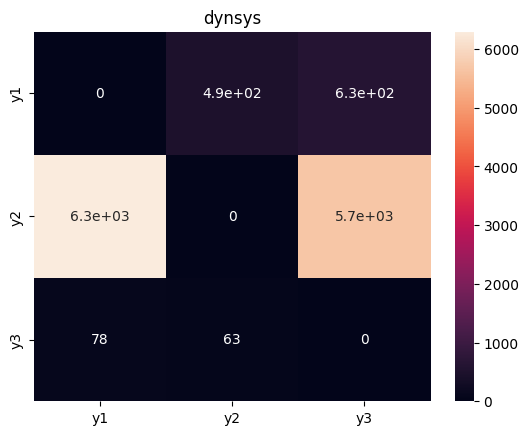

In [28]:
#dynsys
ax = plt.axes()
sns.heatmap(dynsys_mat.squeeze(), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'])
ax.set_title('dynsys')

Text(0.5, 1.0, 'coh')

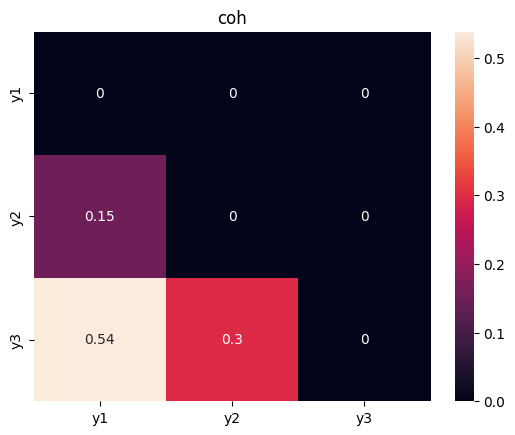

In [30]:
ax = plt.axes()
sns.heatmap(coh_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'])
ax.set_title('coh')

Text(0.5, 1.0, 'ciplv')

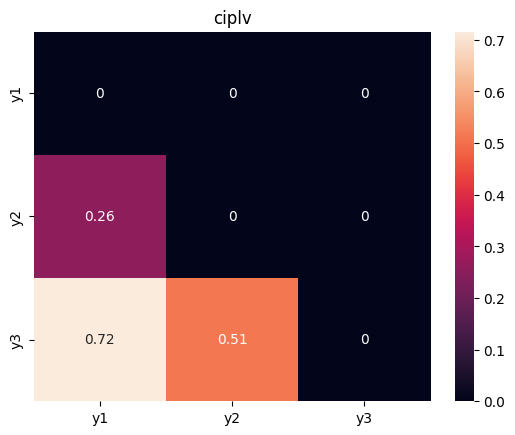

In [31]:
ax = plt.axes()
sns.heatmap(ciplv_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'])
ax.set_title('ciplv')

Text(0.5, 1.0, 'gpdc')

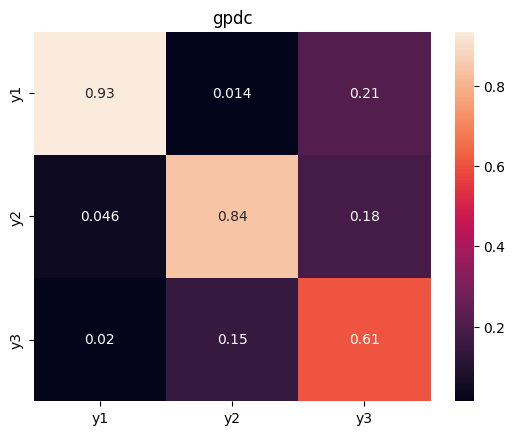

In [32]:
ax = plt.axes()
sns.heatmap(gpdc_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'])
ax.set_title('gpdc')

Text(0.5, 1.0, 'ddtf')

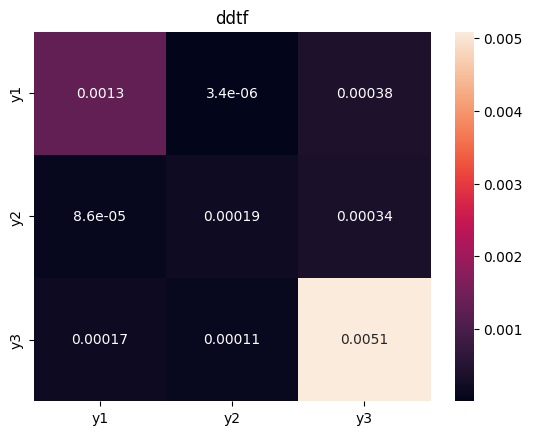

In [33]:
ax = plt.axes()
sns.heatmap(ddtf_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'])
ax.set_title('ddtf')

Text(0.5, 1.0, 'psgp')

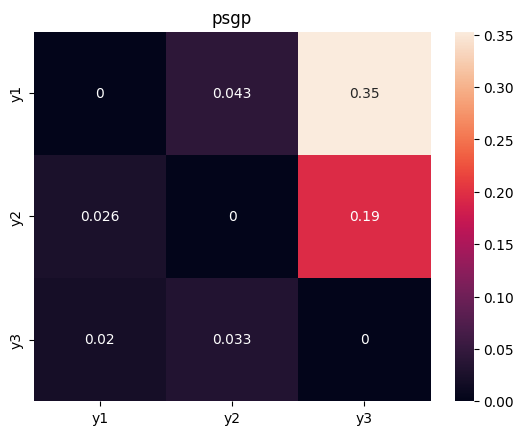

In [34]:
ax = plt.axes()
sns.heatmap(psgp_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'])
ax.set_title('psgp')

#### y1, y2 not present

In [35]:
for i in np.arange(2, len(time)):
    y3_a2[i] = -(rho**2)*y3_a2[i-2] + noise3[i]
    y1_a2[i] = y3_a2[i-2]-(rho**2)*y1_a2[i-2] + noise1[i]
    y2_a2[i] = y3_a2[i-2] - (rho**2)*y2_a2[i-2] + noise2[i]

In [36]:
## simulated data
sim_data = np.array([y1_a2,y2_a2,y3_a2])
info = mne.create_info(ch_names=["y1", "y2", "y3"], ch_types=["eeg"]*3, sfreq=100)
simulated_raw = mne.io.RawArray(sim_data, info)
epochs = mne.make_fixed_length_epochs(simulated_raw, duration=10)

## estimations
#dynsys
epoch_idx = np.arange(1)
region = ['y1','y2','y3']
dynsys_mat,cond_num,mse,snr = dynsys.dynSys(epochs.get_data(), epoch_idx, region, sampling_time=0.01)

#coh 
mne_con = spectral_connectivity_epochs(epochs, method='coh', sfreq=sfreq, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
coh_mat = mne_con.get_data(output="dense")

#ciplv
mne_con = spectral_connectivity_epochs(epochs, method='ciplv', sfreq=sfreq, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
ciplv_mat = mne_con.get_data(output="dense")

#gpdc
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'generalized_partial_directed_coherence')()
gpdc_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#ddtf
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'direct_directed_transfer_function')()
ddtf_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#psgp
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'pairwise_spectral_granger_prediction')()
psgp_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

Creating RawArray with float64 data, n_channels=3, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 1000 original time points ...
0 bad epochs dropped


  0%|          | 0/1 [00:00<?, ?it/s]

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.000s..9.990s for estimation (1000 points)
    frequencies: 8.0Hz..13.0Hz (51 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.

In [ ]:
## heatmaps

Text(0.5, 1.0, 'dynsys')

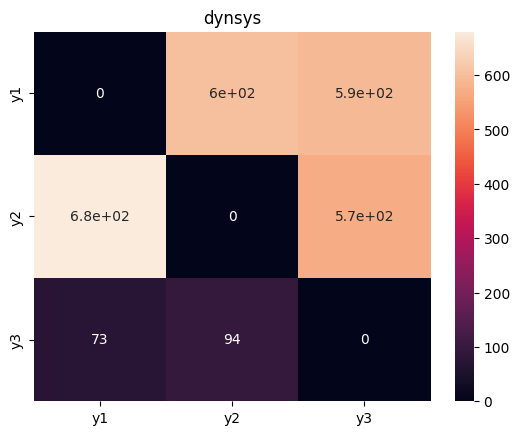

In [37]:
ax = plt.axes()
sns.heatmap(dynsys_mat.squeeze(), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'])
ax.set_title('dynsys')

Text(0.5, 1.0, 'coh')

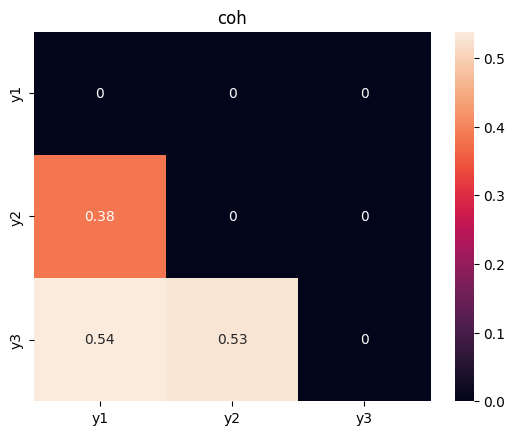

In [38]:
ax = plt.axes()
sns.heatmap(coh_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'])
ax.set_title('coh')

Text(0.5, 1.0, 'ciplv')

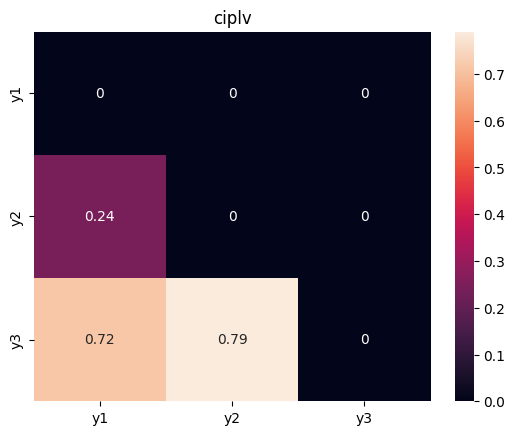

In [39]:
ax = plt.axes()
sns.heatmap(ciplv_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'])
ax.set_title('ciplv')

Text(0.5, 1.0, 'gpdc')

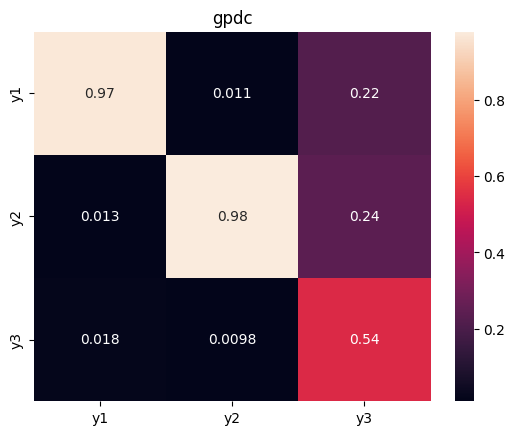

In [40]:
ax = plt.axes()
sns.heatmap(gpdc_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'])
ax.set_title('gpdc')

Text(0.5, 1.0, 'ddtf')

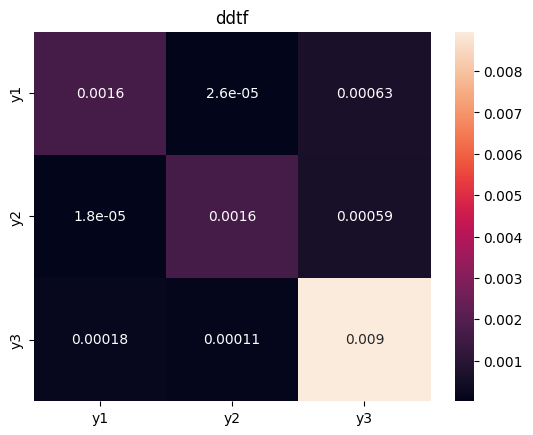

In [41]:
ax = plt.axes()
sns.heatmap(ddtf_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'])
ax.set_title('ddtf')

Text(0.5, 1.0, 'psgp')

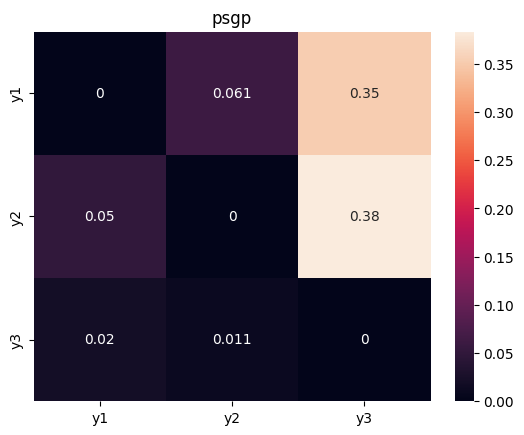

In [42]:
ax = plt.axes()
sns.heatmap(psgp_mat.mean(2), annot=True, xticklabels=['y1','y2','y3'], yticklabels=['y1','y2','y3'])
ax.set_title('psgp')

In [ ]:
#ddtf > gpdc > psgp
#ddtf designed for indirect connectivity
#dynsys behaves similarly to coh but in a more directed fashion